## Choosing features and metrics for nearest neighbor search

In [1]:
import pandas as pd
import matplotlib.pyplot as plt          # plotting
import numpy as np                       # dense matrices
from scipy.sparse import csr_matrix      # sparse matrices
from sklearn.neighbors import NearestNeighbors

In [2]:
%matplotlib inline

In [3]:
wiki = pd.read_csv('./people_wiki.csv')

In [4]:
wiki.head(5)

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...


In [5]:
wiki.shape

(59071, 3)

In [7]:
# wiki.reset_index(inplace=True, drop=False)

In [8]:
# wiki.rename(columns={'index':'id'}, inplace=True)

## Extract word count vectors 

In [6]:
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']
    
    return csr_matrix( (data, indices, indptr), shape)

In [7]:
word_count = load_sparse_csr('people_wiki_word_count.npz')
word_count.shape

(59071, 547979)

In [8]:
word_tfIdf = load_sparse_csr('./people_wiki_tf_idf.npz')
word_tfIdf.shape

(59071, 547979)

In [30]:
import json
with open('./people_wiki_map_index_to_word.json', 'r') as f: # Reads the list of most frequent words
    map_index_to_word = json.load(f)

In [11]:
import string
def remove_punctuation(text):
    return text.translate(string.punctuation) 
wiki['text_clean'] = wiki['text'].apply(remove_punctuation)

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
# Use this token pattern to keep single-letter words
# First, learn vocabulary from the training data and assign columns to words
# Then convert the training data into a sparse matrix
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')

    
word_count_matrix = vectorizer.fit_transform(wiki['text_clean'])

In [15]:
word_count_matrix

<59071x548465 sparse matrix of type '<class 'numpy.int64'>'
	with 10379588 stored elements in Compressed Sparse Row format>

## Find nearest neighbors using word count vectors

In [16]:
from sklearn.neighbors import NearestNeighbors

model = NearestNeighbors(metric='euclidean', algorithm='brute')
model.fit(word_count)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='euclidean',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [17]:
print (wiki[wiki['name'] == 'Barack Obama'])

                                              URI          name  \
35817  <http://dbpedia.org/resource/Barack_Obama>  Barack Obama   

                                                    text  \
35817  barack hussein obama ii brk husen bm born augu...   

                                              text_clean  
35817  barack hussein obama ii brk husen bm born augu...  


In [18]:
distances, indices = model.kneighbors(word_count[35817], n_neighbors=10) # 1st

In [19]:
neighbors = pd.DataFrame({'distance':distances.flatten(), 'id':indices.flatten()})

In [21]:
wiki.reset_index(inplace=True, drop=False)
wiki.rename(columns={'index':'id'}, inplace=True)
wiki.merge(neighbors, on='id').sort_values(by='distance')[['id','name','distance']]

,id,name,distance
8,35817,Barack Obama,0.000000
4,24478,Joe Biden,33.075671
5,28447,George W. Bush,34.394767
7,35357,Lawrence Summers,36.152455
2,14754,Mitt Romney,36.166283
1,13229,Francisco Barrio,36.331804
6,31423,Walter Mondale,36.400549
3,22745,Wynn Normington Hugh-Jones,36.496575
9,36364,Don Bonker,36.633318
0,9210,Andy Anstett,36.959437


## Interpreting the nearest neighbors

All of the 10 people are politicians, but about half of them have rather tenuous connections with Obama, other than the fact that they are politicians.

Francisco Barrio is a Mexican politician, and a former governor of Chihuahua.
Walter Mondale and Don Bonker are Democrats who made their career in late 1970s.
Wynn Normington Hugh-Jones is a former British diplomat and Liberal Party official.
Andy Anstett is a former politician in Manitoba, Canada.
Nearest neighbors with raw word counts got some things right, showing all politicians in the query result, but missed finer and important details.

For instance, let's find out why Francisco Barrio was considered a close neighbor of Obama. To do this, let's look at the most frequently used words in each of Barack Obama and Francisco Barrio's pages.

First, run the following cell to obtain the word_count column, which represents the word count vectors in the dictionary form. This way, we can quickly recognize words of great importance.

In [33]:
def unpack_dict(matrix, map_index_to_word):
    
    table = sorted(map_index_to_word, key=map_index_to_word.get)
    
    
    data = matrix.data
    indices = matrix.indices
    indptr = matrix.indptr
    
    num_doc = matrix.shape[0]

    return [{k:v for k,v in zip([table[word_id] for word_id in indices[indptr[i]:indptr[i+1]] ],
                                 data[indptr[i]:indptr[i+1]].tolist())} \
               for i in range(num_doc) ]

wiki['word_count'] = unpack_dict(word_count, map_index_to_word)

In [29]:
map_index_to_word['selection']

546696

### Nearest Neighbor searchs by word counts, TF -IDF, Euclidean and Cosine Distance and validation by apprearces of similar words

In [38]:
def top_words(name):
    """
    Get a table of the most frequent words in the given person's wikipedia page.
    """
    row = wiki[wiki['name'] == name]
    word_count_table = pd.DataFrame.from_dict(row['word_count'].values[0], orient='index')
    word_count_table.reset_index(drop=False, inplace=True)
    word_count_table.rename(columns={'index': 'word', 0: 'count'}, inplace=True)
    return word_count_table.sort_values('count', ascending=False)

obama_words = top_words('Barack Obama')
print ("Obama Words")
print (obama_words.head())

barrio_words = top_words('Francisco Barrio')
print ("Barrio Words")
print (barrio_words.head())

Obama Words
    word  count
272  the     40
270   in     30
271  and     21
269   of     18
266   to     14
Barrio Words
    word  count
224  the     36
221   of     24
223  and     18
222   in     17
212   he     10


In [39]:
combined_words = obama_words.merge(barrio_words, on='word')
combined_words.rename(columns={'count_x':'count_Obama', 'count_y': 'count_Barrio'}, inplace=True)
combined_words.sort_values('count_Obama', ascending=False, inplace=True)

In [42]:
topObamaWords = combined_words.head()['word'].values
topObamaWords = set(topObamaWords)

In [43]:
topObamaWords

{'and', 'in', 'of', 'the', 'to'}

In [44]:
def has_top_words(word_count_vector):
    # extract the keys of word_count_vector and convert it to a set 
    unique_words = set(word_count_vector.keys())
    if len(topObamaWords.intersection(unique_words)) == len(topObamaWords):
        return True
    else:
        return False

wiki['has_top_words'] = wiki['word_count'].apply(has_top_words)

In [45]:
wiki['has_top_words'].value_counts()

True     56066
False     3005
Name: has_top_words, dtype: int64

In [46]:
print ('Output from your function:', has_top_words(wiki.loc[32]['word_count']))
print ('Correct output: True')
print ('Also check the length of unique_words. It should be 167')
print ('Actual length of unique_words: {}'.format(len(wiki.loc[32]['word_count'])))

print ('Output from your function:', has_top_words(wiki.loc[33]['word_count']))
print ('Correct output: False')
print ('Also check the length of unique_words. It should be 188')
print ('Actual length of unique_words: {}'.format(len(wiki.loc[33]['word_count'])))

Output from your function: True
Correct output: True
Also check the length of unique_words. It should be 167
Actual length of unique_words: 167
Output from your function: False
Correct output: False
Also check the length of unique_words. It should be 188
Actual length of unique_words: 188


In [47]:
from sklearn.metrics.pairwise import euclidean_distances

In [48]:
obamaIndex = wiki[wiki['name'] == 'Barack Obama'].index.values[0]
bushIndex = wiki[wiki['name'] == 'George W. Bush'].index.values[0]
bidenIndex = wiki[wiki['name'] == 'Joe Biden'].index.values[0]   

In [49]:
totalWords = word_count.shape[1]

In [50]:
pairWiseDistances = euclidean_distances(np.array([word_count.getrow(obamaIndex).toarray()[0],
                                                  word_count.getrow(bushIndex).toarray()[0],
                                                  word_count.getrow(bidenIndex).toarray()[0]]))
print (pairWiseDistances)

[[ 0.         34.39476704 33.07567082]
 [34.39476704  0.         32.75667871]
 [33.07567082 32.75667871  0.        ]]


In [55]:
obama_words = top_words('Barack Obama')
bush_words = top_words('George W. Bush')

In [58]:
ob_combined_words = pd.merge(obama_words, bush_words, how='inner', on = 'word')
ob_combined_words.rename(columns={'count_x':'count_Obama', 'count_y': 'count_Bush'}, inplace=True)
ob_combined_words.sort_values('count_Obama', ascending=False).head()

,word,count_Obama,count_Bush
0,the,40,39
1,in,30,22
2,and,21,14
3,of,18,14
4,to,14,11


In [59]:
ob_combined_words.head(10)

,word,count_Obama,count_Bush
0,the,40,39
1,in,30,22
2,and,21,14
3,of,18,14
4,to,14,11
5,his,11,6
6,act,8,3
7,he,7,8
8,a,7,6
9,law,6,1


In [61]:
wiki['tf_idf'] = unpack_dict(word_tfIdf, map_index_to_word)

In [62]:
model_tf_idf = NearestNeighbors(metric='euclidean', algorithm='brute')
model_tf_idf.fit(word_tfIdf)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='euclidean',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [63]:
distances, indices = model_tf_idf.kneighbors(word_tfIdf[35817], n_neighbors=10)

In [64]:
neighbors = pd.DataFrame({'distance':distances.flatten(), 'id':indices.flatten()})

wiki.merge(neighbors, on='id').sort_values(by='distance')[['id','name','distance']]

,id,name,distance
3,35817,Barack Obama,0.000000
1,7914,Phil Schiliro,106.861014
9,46811,Jeff Sessions,108.871674
7,44681,Jesse Lee (politician),109.045698
4,38376,Samantha Power,109.108106
0,6507,Bob Menendez,109.781867
5,38714,Eric Stern (politician),109.957788
8,44825,James A. Guest,110.413889
6,44368,Roland Grossenbacher,110.470609
2,33417,Tulsi Gabbard,110.696998


In [66]:
def top_words_tf_idf(name):
    """
    Get a table of the most frequent words in the given person's wikipedia page.
    """
    row = wiki[wiki['name'] == name]
    word_count_table = pd.DataFrame.from_dict(row['tf_idf'].values[0], orient='index')
    word_count_table.reset_index(drop=False, inplace=True)
    word_count_table.rename(columns={'index': 'word', 0: 'tf_idf'}, inplace=True)
    return word_count_table.sort_values('tf_idf', ascending=False)

obama_words = top_words_tf_idf('Barack Obama')
print ("Obama Words")
print (obama_words.head(10))

Schiliro_words = top_words_tf_idf('Phil Schiliro')
print ("Schiliro Words")
print (Schiliro_words.head(10))

Obama Words
            word     tf_idf
71         obama  43.295653
138          act  27.678223
97          iraq  17.747379
129      control  14.887061
191          law  14.722936
69       ordered  14.533374
155     military  13.115933
105  involvement  12.784385
104     response  12.784385
166   democratic  12.410689
Schiliro Words
               word     tf_idf
1          schiliro  21.972991
42            staff  15.856442
17    congressional  13.547088
0   daschleschiliro  10.986495
13            obama   9.621256
2            waxman   9.040585
82        president   9.033587
3          2014from   8.683910
65              law   7.361468
33       consultant   6.913104


In [67]:
combined_words_tf_idf = obama_words.merge(Schiliro_words, on='word')
combined_words_tf_idf.rename(columns={'tf_idf_x':'tf_idf_Obama', 'tf_idf_y': 'tf_idf_Barrio'}, inplace=True)
combined_words_tf_idf.sort_values('tf_idf_Obama', ascending=False, inplace=True)

In [72]:
topObamaWords_tf_idf = combined_words_tf_idf.head(5)['word'].values
topObamaWords_tf_idf = set(topObamaWords_tf_idf)

In [73]:
topObamaWords_tf_idf

{'democratic', 'law', 'obama', 'presidential', 'senate'}

In [79]:
def has_top_words_tf_idf(word_count_vector):
    # extract the keys of word_count_vector and convert it to a set 
    unique_words = set(word_count_vector.keys())
    if len(topObamaWords_tf_idf.intersection(unique_words)) == len(topObamaWords_tf_idf):
        return True
    else:
        return False

wiki['has_top_words_tf_idf'] = wiki['tf_idf'].apply(has_top_words_tf_idf)

In [80]:
wiki['has_top_words_tf_idf'].value_counts()

False    59057
True        14
Name: has_top_words_tf_idf, dtype: int64

In [81]:
pairWiseDistances_tf_idf = euclidean_distances(np.array([word_tfIdf.getrow(obamaIndex).toarray()[0],
                                                  word_tfIdf.getrow(bushIndex).toarray()[0],
                                                  word_tfIdf.getrow(bidenIndex).toarray()[0]]))
print (pairWiseDistances_tf_idf)

[[  0.         128.8404199  123.29745601]
 [128.8404199    0.         134.42672222]
 [123.29745601 134.42672222   0.        ]]


In [82]:
# Comptue length of all documents
def compute_length(row):
    return len(row['text'].split(' '))

wiki['length'] = wiki.apply(compute_length, axis = 1)

In [84]:
nn_10_tf_idf = wiki.merge(neighbors, on='id').sort_values(by='distance')[['id','name','length', 'distance']]

In [85]:
nn_10_tf_idf

,id,name,length,distance
3,35817,Barack Obama,540,0.000000
1,7914,Phil Schiliro,208,106.861014
9,46811,Jeff Sessions,230,108.871674
7,44681,Jesse Lee (politician),216,109.045698
4,38376,Samantha Power,310,109.108106
0,6507,Bob Menendez,220,109.781867
5,38714,Eric Stern (politician),255,109.957788
8,44825,James A. Guest,215,110.413889
6,44368,Roland Grossenbacher,201,110.470609
2,33417,Tulsi Gabbard,228,110.696998


In [86]:
distances, indices = model_tf_idf.kneighbors(word_tfIdf[35817], n_neighbors=100)

neighbors_100 = pd.DataFrame({'distance':distances.flatten(), 'id':indices.flatten()})

nn_100_tf_idf = wiki.merge(neighbors_100, on='id').sort_values(by='distance')[['id','name','length', 'distance']]

/anaconda3/envs/AI-ML/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


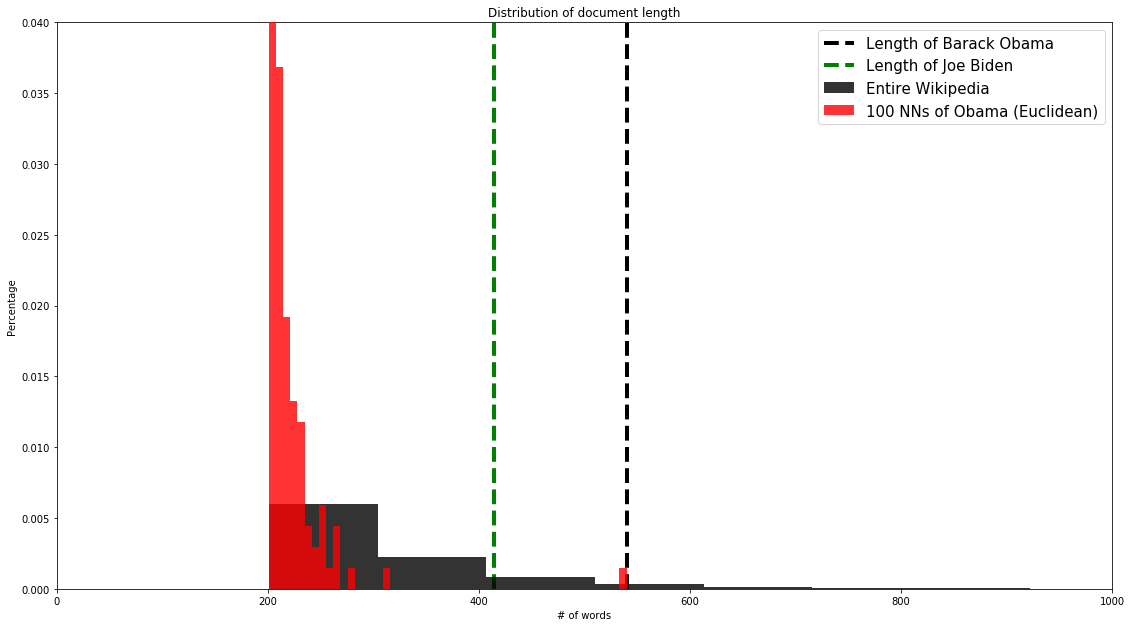

In [88]:
plt.figure(figsize=(16,9))
plt.hist(wiki['length'], 50, color='k', edgecolor='None', histtype='stepfilled', normed=True,
         label='Entire Wikipedia', zorder=3, alpha=0.8)
plt.hist(nn_100_tf_idf['length'], 50, color='r', edgecolor='None', histtype='stepfilled', normed=True,
         label='100 NNs of Obama (Euclidean)', zorder=10, alpha=0.8)
plt.axvline(x=int(wiki['length'][wiki['name'] == 'Barack Obama']), color='k', linestyle='--', linewidth=4,
           label='Length of Barack Obama', zorder=2)  # convert series to integer
plt.axvline(x=int(wiki['length'][wiki['name'] == 'Joe Biden']), color='g', linestyle='--', linewidth=4,
           label='Length of Joe Biden', zorder=1)   # convert series to integer
plt.axis([0, 1000, 0, 0.04])

plt.legend(loc='best', prop={'size':15})
plt.title('Distribution of document length')
plt.xlabel('# of words')
plt.ylabel('Percentage')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

To remove this bias, we turn to cosine distances: $$
d(\mathbf{x},\mathbf{y}) = 1 - \frac{\mathbf{x}^T\mathbf{y}}{\|\mathbf{x}\| \|\mathbf{y}\|}
$$ Cosine distances let us compare word distributions of two articles of varying lengths.
Let us train a new nearest neighbor model, this time with cosine distances. We then repeat the search for Obama's 100 nearest neighbors.

In [89]:
model2_tf_idf = NearestNeighbors(algorithm='brute', metric='cosine')
model2_tf_idf.fit(word_tfIdf)

distances, indices = model2_tf_idf.kneighbors(word_tfIdf[35817], n_neighbors=100)

neighbors_100 = pd.DataFrame({'distance':distances.flatten(), 'id':indices.flatten()})

nn_100_tf_idf = wiki.merge(neighbors_100, on='id').sort_values(by='distance')[['id','name','length', 'distance']]

/anaconda3/envs/AI-ML/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


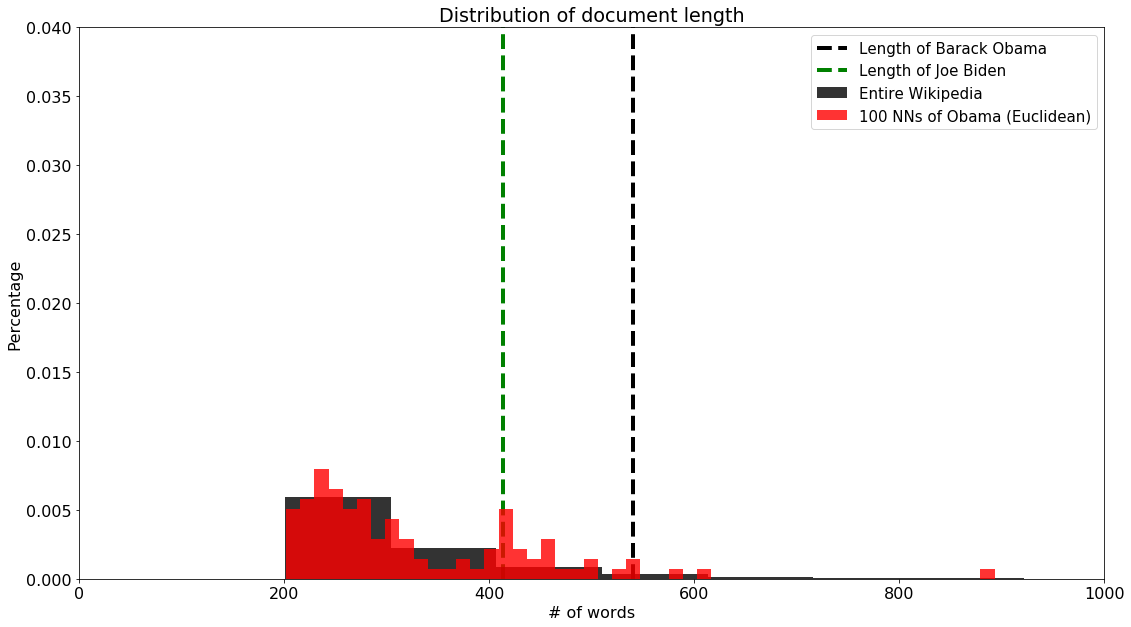

In [90]:
plt.figure(figsize=(16,9))
plt.hist(wiki['length'], 50, color='k', edgecolor='None', histtype='stepfilled', normed=True,
         label='Entire Wikipedia', zorder=3, alpha=0.8)
plt.hist(nn_100_tf_idf['length'], 50, color='r', edgecolor='None', histtype='stepfilled', normed=True,
         label='100 NNs of Obama (Euclidean)', zorder=10, alpha=0.8)
plt.axvline(x=int(wiki['length'][wiki['name'] == 'Barack Obama']), color='k', linestyle='--', linewidth=4,
           label='Length of Barack Obama', zorder=2)  # convert series to integer
plt.axvline(x=int(wiki['length'][wiki['name'] == 'Joe Biden']), color='g', linestyle='--', linewidth=4,
           label='Length of Joe Biden', zorder=1)   # convert series to integer
plt.axis([0, 1000, 0, 0.04])

plt.legend(loc='best', prop={'size':15})
plt.title('Distribution of document length')
plt.xlabel('# of words')
plt.ylabel('Percentage')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

## Problem with cosine distances: tweets vs. long articles

In [91]:
tweet = {'act': 3.4597778278724887,
 'control': 3.721765211295327,
 'democratic': 3.1026721743330414,
 'governments': 4.167571323949673,
 'in': 0.0009654063501214492,
 'law': 2.4538226269605703,
 'popular': 2.764478952022998,
 'response': 4.261461747058352,
 'to': 0.04694493768179923}

In [98]:
word_indices = [map_index_to_word[w] for w,v in tweet.items() if w in map_index_to_word.keys()]

tweet_tf_idf = csr_matrix( (list(tweet.values()), ([0]*len(word_indices), word_indices)),
                          shape=(1, word_tfIdf.shape[1]) )

In [100]:
from sklearn.metrics.pairwise import cosine_distances

obama_tf_idf = word_tfIdf[35817]
print (cosine_distances(obama_tf_idf, tweet_tf_idf))

[[0.70591838]]


In [104]:
nn_100_tf_idf.head(10)

,id,name,length,distance
59,35817,Barack Obama,540,0.000000
45,24478,Joe Biden,414,0.703139
65,38376,Samantha Power,310,0.742982
98,57108,Hillary Rodham Clinton,580,0.758358
67,38714,Eric Stern (politician),255,0.770561
79,46140,Robert Gibbs,257,0.784678
15,6796,Eric Holder,232,0.788039
77,44681,Jesse Lee (politician),216,0.790926
36,18827,Henry Waxman,279,0.798323
3,2412,Joe the Plumber,217,0.799466
